### Importing librarys

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import combinations
from collections import Counter


### Concatenate all 12 files of data in one

In [2]:
files = [file for file in os.listdir("./Sales_Data/")]

annual_data = pd.DataFrame()

for file in files:
    annual_data = pd.concat([annual_data, pd.read_csv("./Sales_Data/"+file)])

annual_data.to_csv("all_months_data.csv", index=False)

### Read the new file with all 12 months of data
- Why not use annual_data from above?

In [3]:
all_data = pd.read_csv("all_months_data.csv")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,259358,34in Ultrawide Monitor,1,379.99,10/28/19 10:56,"609 Cherry St, Dallas, TX 75001"
1,259359,27in 4K Gaming Monitor,1,389.99,10/28/19 17:26,"225 5th St, Los Angeles, CA 90001"
2,259360,AAA Batteries (4-pack),2,2.99,10/24/19 17:20,"967 12th St, New York City, NY 10001"
3,259361,27in FHD Monitor,1,149.99,10/14/19 22:26,"628 Jefferson St, New York City, NY 10001"
4,259362,Wired Headphones,1,11.99,10/07/19 16:10,"534 14th St, Los Angeles, CA 90001"


### Finding out what was the best month of sales and how much was earned in that month
- Why use the annual csv file instead of the files of each month?

##### Cleaning the data, excluding rows with null values and invalid values

In [4]:
all_data = all_data.drop(all_data[all_data["Order ID"] == "Order ID"].index)

all_data.dropna(inplace=True)

all_data = all_data.reset_index(drop=True)

all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,259358,34in Ultrawide Monitor,1,379.99,10/28/19 10:56,"609 Cherry St, Dallas, TX 75001"
1,259359,27in 4K Gaming Monitor,1,389.99,10/28/19 17:26,"225 5th St, Los Angeles, CA 90001"
2,259360,AAA Batteries (4-pack),2,2.99,10/24/19 17:20,"967 12th St, New York City, NY 10001"
3,259361,27in FHD Monitor,1,149.99,10/14/19 22:26,"628 Jefferson St, New York City, NY 10001"
4,259362,Wired Headphones,1,11.99,10/07/19 16:10,"534 14th St, Los Angeles, CA 90001"


#### Parsing the column "Order date" to date time format

In [5]:
all_data["Order Date"] = pd.to_datetime(all_data["Order Date"])

/tmp/ipykernel_299194/2617628323.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data["Order Date"] = pd.to_datetime(all_data["Order Date"])


#### Creating a new column "month"

In [6]:
all_data["Month"] = all_data["Order Date"].dt.month

all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,259358,34in Ultrawide Monitor,1,379.99,2019-10-28 10:56:00,"609 Cherry St, Dallas, TX 75001",10
1,259359,27in 4K Gaming Monitor,1,389.99,2019-10-28 17:26:00,"225 5th St, Los Angeles, CA 90001",10
2,259360,AAA Batteries (4-pack),2,2.99,2019-10-24 17:20:00,"967 12th St, New York City, NY 10001",10
3,259361,27in FHD Monitor,1,149.99,2019-10-14 22:26:00,"628 Jefferson St, New York City, NY 10001",10
4,259362,Wired Headphones,1,11.99,2019-10-07 16:10:00,"534 14th St, Los Angeles, CA 90001",10


#### Converting columns "Price Each" and "Quantity Ordered" to numeric

In [7]:
all_data["Price Each"] = pd.to_numeric(all_data["Price Each"])
all_data["Quantity Ordered"] = pd.to_numeric(all_data["Quantity Ordered"])

#### Creating a new column "total price" (price each * quantity ordered)

In [8]:
all_data["Total Price"] = all_data["Quantity Ordered"] * all_data["Price Each"]

#### New data frame with the data I'm looking for

In [9]:
sales_by_month = all_data.groupby("Month").agg({"Total Price": "sum"})

sales_by_month.sort_values(by="Month", ascending=True, inplace=True)

sales_by_month = sales_by_month.reset_index()

sales_by_month["Total Price"] = sales_by_month["Total Price"].apply(lambda x: round(x/1000000, 2))

sales_by_month.head(12)


,Month,Total Price
0,1,1.82
1,2,2.20
2,3,2.81
3,4,3.39
4,5,3.15
5,6,2.58
6,7,2.65
7,8,2.24
8,9,2.10
9,10,3.74


#### Ploting sales by month

In [10]:
# plt.bar(sales_by_month["Month"], sales_by_month["Total Price"])
# plt.xticks(sales_by_month["Month"], rotation=45, ha="right")
# plt.ylabel("Sales (million dollars)")
# plt.xlabel("Month")

# plt.title("Sales by month")

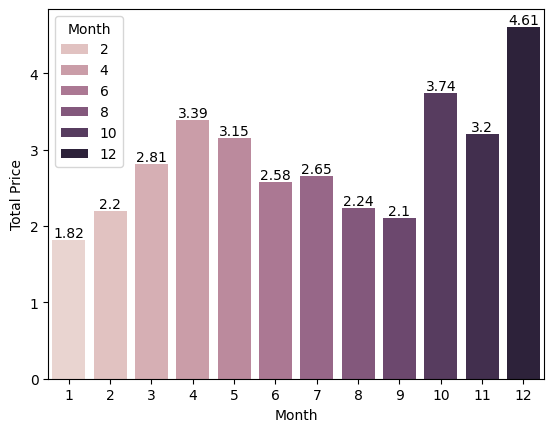

In [11]:
fig_sales_by_month = sns.barplot(data=sales_by_month, x="Month", y="Total Price", hue="Month")

for i in fig_sales_by_month.containers:
    fig_sales_by_month.bar_label(i)

### Finding out which city had the highest number of sales

#### Creating City column

In [12]:
def get_city(address):
    return address.split(",")[1]

def get_state(address):
    state_plus_code = address.split(",")[2]
    return state_plus_code.split(" ")[1]

all_data["City"] = all_data["Purchase Address"].apply(lambda x: (f"{get_city(x)}, {get_state(x)}"))

#### New dataframe with sales by city

In [13]:
sales_by_city = all_data.groupby("City").agg({"Total Price": "sum"})

sales_by_city = sales_by_city.reset_index()

sales_by_city["Total Price"] = sales_by_city["Total Price"].apply(lambda x: round(x/1000000, 2))

sales_by_city.head(10)

,City,Total Price
0,"Atlanta, GA",2.80
1,"Austin, TX",1.82
2,"Boston, MA",3.66
3,"Dallas, TX",2.77
4,"Los Angeles, CA",5.45
5,"New York City, NY",4.66
6,"Portland, ME",0.45
7,"Portland, OR",1.87
8,"San Francisco, CA",8.26
9,"Seattle, WA",2.75


#### Ploting sales by city

In [14]:
# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i,y[i]/2,y[i], rotation="vertical")

# plt.bar(sales_by_city["City"], sales_by_city["Total Price"])
# plt.xticks(sales_by_city["City"], rotation=45, ha="right")
# addlabels(sales_by_city["City"], sales_by_city["Total Price"])
# plt.ylabel("Sales (million dollars)")
# plt.xlabel("City")
# plt.title("Sales by City")

/tmp/ipykernel_299194/351752086.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_sales_by_city.set_xticklabels(fig_sales_by_city.get_xticklabels(), rotation=45, horizontalalignment="right")


[Text(0, 0, ' Atlanta, GA'),
 Text(1, 0, ' Austin, TX'),
 Text(2, 0, ' Boston, MA'),
 Text(3, 0, ' Dallas, TX'),
 Text(4, 0, ' Los Angeles, CA'),
 Text(5, 0, ' New York City, NY'),
 Text(6, 0, ' Portland, ME'),
 Text(7, 0, ' Portland, OR'),
 Text(8, 0, ' San Francisco, CA'),
 Text(9, 0, ' Seattle, WA')]

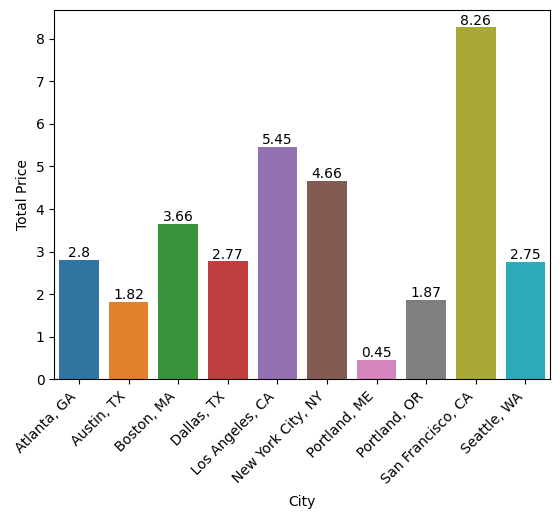

In [15]:
fig_sales_by_city = sns.barplot(data=sales_by_city, x="City", y="Total Price", hue="City")

for i in fig_sales_by_city.containers:
    fig_sales_by_city.bar_label(i)

fig_sales_by_city.set_xticklabels(fig_sales_by_city.get_xticklabels(), rotation=45, horizontalalignment="right")

### Finding out what products are most often sold together

#### New dataframe with sales that has more than one product

In [16]:
sold_together = all_data[all_data["Order ID"].duplicated(keep=False)]

sold_together["Grouped"] = sold_together.groupby("Order ID")["Product"].transform(lambda x: ",".join(x))
sold_together2 = sold_together[["Order ID", "Grouped"]].drop_duplicates()

/tmp/ipykernel_299194/738711526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sold_together['Grouped'] = sold_together.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))


#### Top 10 pair of products sold together

In [17]:
count = Counter()

for row in sold_together2["Grouped"]:
    products_sold_together = row.split(",")
    count.update(Counter(combinations(products_sold_together, 2)))

for key,value in count.most_common(10):
    print(key, value)

('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


In [18]:
def producs_sorted(products):
    products_list = products.split(",")
    products_list = sorted(products_list)
    return products_list

sold_together2 = sold_together2["Grouped"].apply(lambda x: producs_sorted(x))

sold_together2.head()

62          [Google Phone, USB-C Charging Cable]
65          [Google Phone, USB-C Charging Cable]
82            [Lightning Charging Cable, iPhone]
103    [34in Ultrawide Monitor, ThinkPad Laptop]
123           [AAA Batteries (4-pack), LG Dryer]
Name: Grouped, dtype: object

### Finding out what product sold the most

#### New dataframe amout of sales by product

In [19]:
sales_by_product = all_data.groupby("Product").agg({"Quantity Ordered": "sum"})

sales_by_product = sales_by_product.reset_index()

sales_by_product.head()

,Product,Quantity Ordered
0,20in Monitor,4129
1,27in 4K Gaming Monitor,6244
2,27in FHD Monitor,7550
3,34in Ultrawide Monitor,6199
4,AA Batteries (4-pack),27635


In [20]:
# plt.bar(sales_by_product["Product"], sales_by_product["Quantity Ordered"])
# plt.xticks(sales_by_product["Product"], rotation=45, ha="right", size=7)
# addlabels(sales_by_product["Product"], sales_by_product["Quantity Ordered"])
# plt.ylabel("Amount")
# plt.xlabel("Product")
# plt.title("Product amount")

/tmp/ipykernel_299194/3331117328.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig_sales_by_product.set_xticklabels(fig_sales_by_product.get_xticklabels(), rotation=45, horizontalalignment="right")


[Text(0, 0, '20in Monitor'),
 Text(1, 0, '27in 4K Gaming Monitor'),
 Text(2, 0, '27in FHD Monitor'),
 Text(3, 0, '34in Ultrawide Monitor'),
 Text(4, 0, 'AA Batteries (4-pack)'),
 Text(5, 0, 'AAA Batteries (4-pack)'),
 Text(6, 0, 'Apple Airpods Headphones'),
 Text(7, 0, 'Bose SoundSport Headphones'),
 Text(8, 0, 'Flatscreen TV'),
 Text(9, 0, 'Google Phone'),
 Text(10, 0, 'LG Dryer'),
 Text(11, 0, 'LG Washing Machine'),
 Text(12, 0, 'Lightning Charging Cable'),
 Text(13, 0, 'Macbook Pro Laptop'),
 Text(14, 0, 'ThinkPad Laptop'),
 Text(15, 0, 'USB-C Charging Cable'),
 Text(16, 0, 'Vareebadd Phone'),
 Text(17, 0, 'Wired Headphones'),
 Text(18, 0, 'iPhone')]

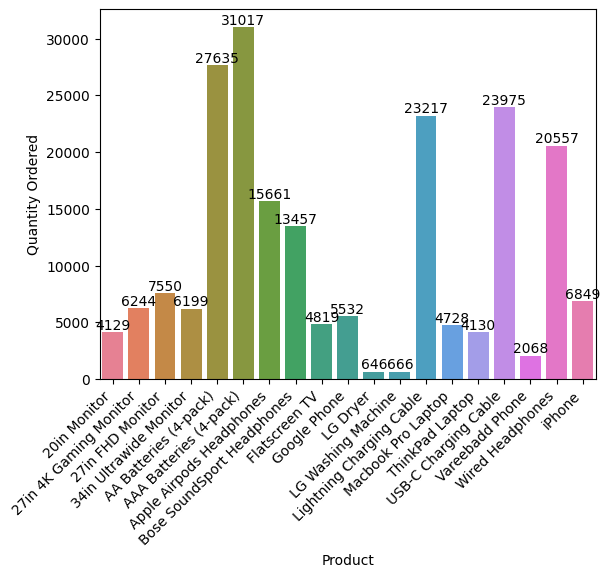

In [21]:
fig_sales_by_product = sns.barplot(data=sales_by_product, x="Product", y="Quantity Ordered", hue="Product")

for i in fig_sales_by_product.containers:
    fig_sales_by_product.bar_label(i)

fig_sales_by_product.set_xticklabels(fig_sales_by_product.get_xticklabels(), rotation=45, horizontalalignment="right")